## Another way

In [37]:
import zipfile
import os

zip_file_path = "/content/lipreading (3).zip"
extract_to = "/content/dataset"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to {extract_to}")

Files extracted to /content/dataset


In [ ]:
import numpy as np

# Load a .npy file
data = np.load('/content/videos/content/av/video_only/data/pretrain/مايكل/اخبارك/1.npy')

# Print the loaded data
print(data)

[[0.16915293 0.         0.         ... 0.00325083 0.         1.3520802 ]
 [0.15657742 0.07740454 0.         ... 0.10639144 0.22115068 0.00289246]
 [0.08491819 0.05146109 0.         ... 0.0299424  0.21767083 0.00766086]
 ...
 [0.08100868 0.16756706 0.         ... 0.07652957 0.48080763 0.00791672]
 [0.08910439 0.20215307 0.         ... 0.038307   0.57738096 0.01817344]
 [0.24282628 0.14799811 0.         ... 0.22793114 0.5148199  0.03891844]]


In [ ]:
import numpy as np

# Load a .npy file
data = np.load('/content/lipreading/انا/02.npy')

# Print the loaded data
print(data.shape)

(83, 512)


In [38]:
def walk_through_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} word in '{dirpath}'.")

In [40]:
walk_through_dir('/content/dataset/lipreading/lipreading')

There are 10 directories and 0 word in '/content/dataset/lipreading/lipreading'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/لا'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/تعب'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/شكرا'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/اكسجين'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/اشعر'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/اكتئاب'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/انا'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/صوت'.
There are 0 directories and 20 word in '/content/dataset/lipreading/lipreading/برد'.
There are 0 directories and 19 word in '/content/dataset/lipreading/lipreading/اريد'.


In [ ]:
import os

dir_path = "/content/lipreading/اخبارك/.ipynb_checkpoints"

if os.path.exists(dir_path) and os.path.isdir(dir_path):
    os.rmdir(dir_path)  # Removes only empty directories
    print(f"{dir_path} has been deleted.")
else:
    print(f"{dir_path} is not a valid directory or does not exist.")

/content/lipreading/اخبارك/.ipynb_checkpoints is not a valid directory or does not exist.


In [41]:
import os
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [42]:
main_dir = "/content/dataset/lipreading/lipreading"
classes = os.listdir(main_dir)  # List all class folders

In [43]:
classes

['لا', 'تعب', 'شكرا', 'اكسجين', 'اشعر', 'اكتئاب', 'انا', 'صوت', 'برد', 'اريد']

In [44]:
class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

In [45]:
max_shape = None

# Step 1: Identify the maximum shape among all .npy files
for class_dir in class_to_idx:
    class_path = os.path.join(main_dir, class_dir)
    if os.path.isdir(class_path):  # Ensure it's a directory
        for npy_file in os.listdir(class_path):
            if npy_file.endswith('.npy'):
                file_path = os.path.join(class_path, npy_file)
                data = np.load(file_path)
                if max_shape is None:
                    max_shape = data.shape
                else:
                    max_shape = tuple(max(max_shape[dim], data.shape[dim]) for dim in range(len(data.shape)))

In [46]:
# Step 2: Pad files to the maximum shape
for class_dir in class_to_idx:
    class_path = os.path.join(main_dir, class_dir)
    if os.path.isdir(class_path):  # Ensure it's a directory
        for npy_file in os.listdir(class_path):
            if npy_file.endswith('.npy'):
                file_path = os.path.join(class_path, npy_file)
                data = np.load(file_path)

                # Calculate padding sizes
                padding = [(0, max_dim - curr_dim) for curr_dim, max_dim in zip(data.shape, max_shape)]

                # Apply padding
                padded_data = np.pad(data, pad_width=padding, mode='constant', constant_values=0)

                # Save the padded file (overwrite or save to a new location)
                np.save(file_path, padded_data)

print("Padding completed. All files have the shape:", max_shape)

Padding completed. All files have the shape: (83, 512)


## Custom Data

In [47]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [48]:
class LipReadingDataset(Dataset):
    def __init__(self, file_paths, labels, pad_value=0):
        self.file_paths = file_paths
        self.labels = labels
        self.pad_value = pad_value

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        data = np.load(self.file_paths[idx])
        label = self.labels[idx]

        # Create padding mask (1 for valid, 0 for padded)
        mask = (data != self.pad_value).astype(np.float32)

        # Flatten the input to match the model's expected input_size
        data = data.flatten()
        mask = mask.flatten()

        return torch.tensor(data, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32), label

## Split Data

In [49]:
# Directory containing class folders
classes = class_to_idx

# Collect file paths and corresponding labels
file_paths = []
labels = []
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

for class_dir in classes:
    class_path = os.path.join(main_dir, class_dir)
    if os.path.isdir(class_path):
        for npy_file in os.listdir(class_path):
            if npy_file.endswith('.npy'):
                file_paths.append(os.path.join(class_path, npy_file))
                labels.append(class_to_idx[class_dir])


## Dataloaders

In [50]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

In [51]:
# Create Dataset instances
train_dataset = LipReadingDataset(train_paths, train_labels)
test_dataset = LipReadingDataset(test_paths, test_labels)

In [52]:
from torch.utils.data import DataLoader

batch_size = 32

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data preparation complete.")
print(f"Train size: {len(train_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

Data preparation complete.
Train size: 159
Test size: 40


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision.datasets import EMNIST
import torchvision.transforms.functional as F
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

# Libraries I added

from torch.optim import Adam, SGD
import torchvision.models as models

In [54]:
class nn3Layer(nn.Module):

  def __init__(self, input_size):
    super(nn3Layer, self).__init__()

    self.layer_1 = nn.Linear(input_size, 1024)
    self.layer_2 = nn.Linear(1024, 512)
    self.layer_3 = nn.Linear(512, 256)
    self.layer_4 = nn.Linear(256, 10)

    self.hidden_activation = nn.ReLU()

  # Forward pass
  def forward(self, x):

    x = self.hidden_activation(self.layer_1(x))
    x = self.hidden_activation(self.layer_2(x))
    x = self.hidden_activation(self.layer_3(x))
    x = self.layer_4(x)

    return x

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Defining the device

model = nn3Layer(83 * 512)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

model.to(device) # Move everything to the device

nn3Layer(
  (layer_1): Linear(in_features=42496, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=256, bias=True)
  (layer_4): Linear(in_features=256, out_features=10, bias=True)
  (hidden_activation): ReLU()
)

In [56]:
epoch_no = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epoch_no):
    model.train()

    epoch_weighted_loss = 0
    correct_train = 0  # Initialize for training accuracy

    for batch_X, mask, batch_y in train_loader:
        batch_X = batch_X.view(-1, 83 * 512).to(device)
        batch_y = batch_y.to(device)

        batch_y_probs = model(batch_X)

        # Calculate the loss
        loss = loss_fn(batch_y_probs, batch_y)

        mask = mask.to(loss.device)

        masked_loss = loss * mask
        loss = masked_loss.sum() / mask.sum()

        # Reset the gradient
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        epoch_weighted_loss += len(batch_y) * loss.item()

        # Calculate the accuracy
        train_batch_y_pred = batch_y_probs.argmax(dim=1)
        correct_train += (train_batch_y_pred == batch_y).sum().item()

    epoch_loss = epoch_weighted_loss / len(train_loader.dataset)
    train_accuracy = correct_train / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation time
    model.eval()
    correctly_labelled = 0

    with torch.no_grad():
        val_epoch_weighted_loss = 0
        for val_batch_X, mask, val_batch_y in test_loader:
            val_batch_X = val_batch_X.view(-1, 83 * 512).to(device)
            val_batch_y = val_batch_y.to(device)

            val_batch_y_probs = model(val_batch_X)
            loss = loss_fn(val_batch_y_probs, val_batch_y)

            val_epoch_weighted_loss += len(val_batch_y) * loss.item()

            val_batch_y_pred = val_batch_y_probs.argmax(dim=1)
            correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()

        val_epoch_loss = val_epoch_weighted_loss / len(test_loader.dataset)
        val_accuracy = correctly_labelled / len(test_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_accuracy)

    print(f'Epoch: {epoch}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. '
          f'labelled {correctly_labelled}/{len(test_loader.dataset)} correctly '
          f'({correctly_labelled / len(test_loader.dataset) * 100}% accuracy)')

print(f'Training complete on device {device}.')

Epoch: 0, train_loss=2.3138547393510924, val_loss=2.286370372772217. labelled 4/40 correctly (10.0% accuracy)
Epoch: 1, train_loss=2.255011650001478, val_loss=2.2573727130889893. labelled 16/40 correctly (40.0% accuracy)
Epoch: 2, train_loss=2.1855144440752907, val_loss=2.213999128341675. labelled 7/40 correctly (17.5% accuracy)
Epoch: 3, train_loss=2.0830280930741027, val_loss=2.1459084033966063. labelled 18/40 correctly (45.0% accuracy)
Epoch: 4, train_loss=1.9716613795022544, val_loss=2.078571844100952. labelled 14/40 correctly (35.0% accuracy)
Epoch: 5, train_loss=1.8185132861887134, val_loss=1.9878747463226318. labelled 16/40 correctly (40.0% accuracy)
Epoch: 6, train_loss=1.6616161889250174, val_loss=1.8850297451019287. labelled 16/40 correctly (40.0% accuracy)
Epoch: 7, train_loss=1.489857110587306, val_loss=1.7924424171447755. labelled 17/40 correctly (42.5% accuracy)
Epoch: 8, train_loss=1.3099966446558635, val_loss=1.6811518669128418. labelled 16/40 correctly (40.0% accuracy)

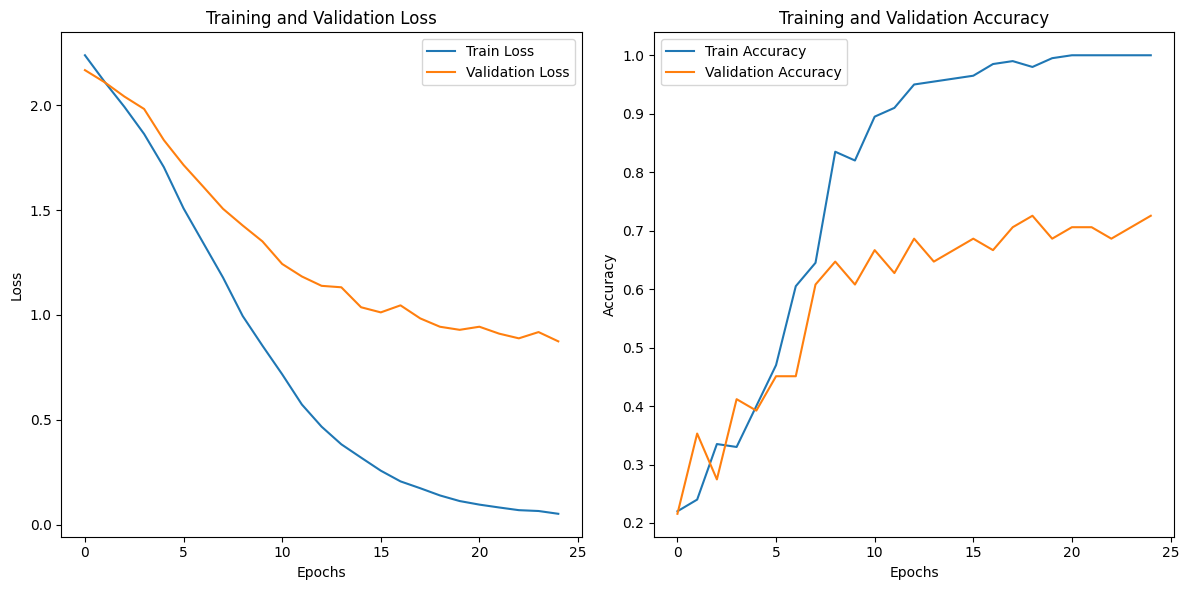

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epoch_no), train_losses, label='Train Loss')
plt.plot(range(epoch_no), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(epoch_no), train_accuracies, label='Train Accuracy')
plt.plot(range(epoch_no), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()